In [1]:
# @Author: Killian Sheriff <Killian>
# @Date:   20-Sep-2020
# @Email:  killian.sheriff@gmail.com / killian.sheriff@mail.mcgill.ca
# @Last modified by:   Killian
# @Last modified time: 20-Sep-2020

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

In [3]:
# set matplotlib parameters (can see all: plt.rcParams.keys())

params = {
    "legend.fontsize": 13,
    "legend.handlelength": 1,
    "font.size": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "figure.facecolor": "white",
    "font.family": "serif",
    "grid.linestyle": ":",
}
matplotlib.rcParams.update(params)

In [4]:
#set functions to show pdf inline.

from wand.image import Image
from wand.display import display


def show_pdf(filename, nb_pages):
    for i in range(nb_pages):
        plt.figure(figsize=(50, 50))
        plt.axis('off')
        pdf = Image(filename="{}[{}]".format(filename, i))
        plt.imshow(pdf)

# Q1: A Smarter Integrator...

In [5]:
def simple_integrate(fun, a, b, tol):
    x = np.linspace(a, b, 5)
    dx = (b - a) / 4.0
    y = fun(x)
    neval = len(x)  #let's keep track of function evaluations
    f1 = (y[0] + 4 * y[2] + y[4]) / 6.0 * (b - a)
    f2 = (y[0] + 4 * y[1] + 2 * y[2] + 4 * y[3] + y[4]) / 12.0 * (b - a)
    myerr = np.abs(f2 - f1)
    if (myerr < tol):
        return (16.0 * f2 - f1) / 15.0, myerr, neval
    else:
        mid = 0.5 * (b + a)
        f_left, err_left, neval_left = simple_integrate(fun, a, mid, tol / 2.0)
        f_right, err_right, neval_right = simple_integrate(
            fun, mid, b, tol / 2.0)
        neval = neval + neval_left + neval_right
        f = f_left + f_right
        err = err_left + err_right
        return f, err, neval

We will create a smarter integrator (using recursion) than the one written in class by not wasting time recalculating common points between iterations and thus saving functions call. 

In [6]:
def smarter_integrator(fun, a, b, tol, f_bounds=['none', 'none', 'none']):
    x = np.linspace(a, b, 5)

    if isinstance(f_bounds[0], str):
        y = fun(x)
        fa, fmid, fb = y[0], y[2], y[-1]
        f_mid_left, f_mid_right = y[1], y[3]
        neval = len(x)
    else:
        fa, fb, fmid = f_bounds
        f_mid_left, f_mid_right = map(fun, [x[1], x[3]])
        neval = 2

    f1 = (fa + 4 * fmid + fb) / 6.0 * (b - a)
    f2 = (fa + 4 * f_mid_left + 2 * fmid + 4 * f_mid_right + fb) / 12.0 * (b -
                                                                           a)

    myerr = np.abs(f2 - f1)
    if myerr < tol:
        return (16.0 * f2 - f1) / 15.0, myerr, neval
    else:
        mid = 0.5 * (b + a)
        f_left, err_left, neval_left = smarter_integrator(
            fun, a, mid, tol / 2.0, [fa, fmid, f_mid_left])
        f_right, err_right, neval_right = smarter_integrator(
            fun, mid, b, tol / 2.0, [fmid, fb, f_mid_right])
        neval = neval + neval_left + neval_right
        f = f_left + f_right
        err = err_left + err_right
        return f, err, neval

In [7]:
def fun1(x):
    return 1.0 / (1.0 + x**2)


def fun2(x, mu=1, sig=0.1):
    return np.exp(-(x - mu)**2 / (2 * sig**2))


def fun3(x):
    return np.cos(x)


def fun4(x):
    return x**4


fun_n = [fun1, fun2, fun3, fun4]
bounds = [(-1, 1), (-1, 1), (-np.pi / 2, np.pi / 2), (-1, 1)]
fun_txt = [
    '1.0 / (1.0 + x**2)', 'np.exp(-(x - 1)**2 / (2 * 0.1**2))', 'np.cos(x)',
    'x**4'
]

for fun, bound, name in zip(fun_n, bounds, fun_txt):
    f_simple, err_simple, neval_simple = simple_integrate(
        fun, bound[0], bound[1], 1e-3)
    f_smarter, err_smarter, neval_smarter = smarter_integrator(
        fun, bound[0], bound[1], 1e-3)
    print('Integrating {} on the interval {}.'.format(name, bound))
    print(
        'Smarter_integrator uses {} less function calls than simple_integrate as it only calls {} functions against {} for simple integrate. \n'
        .format(neval_simple - neval_smarter, neval_smarter, neval_simple))

Integrating 1.0 / (1.0 + x**2) on the interval (-1, 1).
Smarter_integrator uses 18 less function calls than simple_integrate as it only calls 17 functions against 35 for simple integrate. 

Integrating np.exp(-(x - 1)**2 / (2 * 0.1**2)) on the interval (-1, 1).
Smarter_integrator uses 42 less function calls than simple_integrate as it only calls 33 functions against 75 for simple integrate. 

Integrating np.cos(x) on the interval (-1.5707963267948966, 1.5707963267948966).
Smarter_integrator uses 18 less function calls than simple_integrate as it only calls 17 functions against 35 for simple integrate. 

Integrating x**4 on the interval (-1, 1).
Smarter_integrator uses 18 less function calls than simple_integrate as it only calls 17 functions against 35 for simple integrate. 



# Q2: Chebyshev Fit

As seen in class, we will use the X**2 minimization technique to solve for the model parameters. Here, the noise N will be the identitiy matrix. Also, since the Chebyshev range is -1 and 1 we will map the data to this range. 

In [8]:
def map_to_range(x, lower_bnd, upper_bnd):
    a = (upper_bnd - lower_bnd) / (x.max() - x.min())
    b = lower_bnd - a * x.min()
    return a * x + b


def cheb_mat(x, order):
    x = map_to_range(x, -1, 1)
    mat = np.zeros([len(x), order + 1])

    mat[:, 0] = 1.0
    if order > 0:
        mat[:, 1] = x
    if order > 1:
        for i in range(1, order):
            mat[:, i + 1] = 2 * x * mat[:, i] - mat[:, i - 1]
    return mat


def minimize_x2(data, A):
    #lhs = np.dot(A.T, A)  #N is identity so can be ignored here.
    #rhs = np.dot(A.T, data)
    #fit_params = np.dot(np.linalg.inv(lhs), rhs)

    #in class we saw SVD decomposition
    u, s, v = np.linalg.svd(A, 0)
    #print('svd condition is ',s.max()/np.abs(s).min())
    fit_params = v.T @ (np.diag(1 / s) @ (u.T @ data))
    return fit_params

In [9]:
nb_points = 1000
order = 25
accuracy = 1.0e-6

x = np.linspace(0.5, 1.0, nb_points)
data = np.log2(x)


def Cheb_fit(x, nb_points, order, data, accuracy=None):

    A = cheb_mat(x, order)
    fit_params = minimize_x2(data, A)
    pred = np.dot(A, fit_params)

    if accuracy == None:
        return pred

    trunc = 1
    pred = np.dot(A[:, :trunc], fit_params[:trunc])
    while trunc < order and np.abs(pred - data).max() > accuracy:
        trunc += 1
        pred = np.dot(A[:, :trunc], fit_params[:trunc])
        rms = np.std(pred - data)
        max_err = np.abs(pred - data).max()
        print('Trunc: {}, RMS error: {:.2e}, Max error: {:.2e}'.format(
            trunc, rms, max_err))
    return trunc, pred

In [10]:
trunc, pred = Cheb_fit(x, nb_points, order, data, accuracy)
print(
    '\nThus, we need {} truncated polynomial from an order {} Chebyshev fit in order to have an accuracy inferior or equal to {}.'
    .format(trunc, order, accuracy))

Trunc: 2, RMS error: 2.54e-02, Max error: 4.81e-02
Trunc: 3, RMS error: 3.39e-03, Max error: 5.58e-03
Trunc: 4, RMS error: 4.38e-04, Max error: 7.25e-04
Trunc: 5, RMS error: 6.06e-05, Max error: 1.00e-04
Trunc: 6, RMS error: 8.67e-06, Max error: 1.44e-05
Trunc: 7, RMS error: 1.28e-06, Max error: 2.12e-06
Trunc: 8, RMS error: 1.92e-07, Max error: 3.20e-07

Thus, we need 8 truncated polynomial from an order 25 Chebyshev fit in order to have an accuracy inferior or equal to 1e-06.


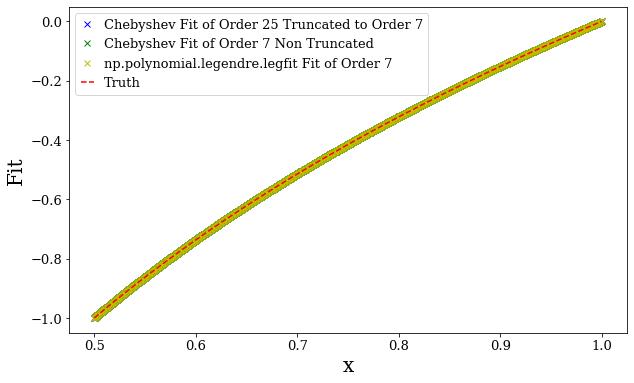

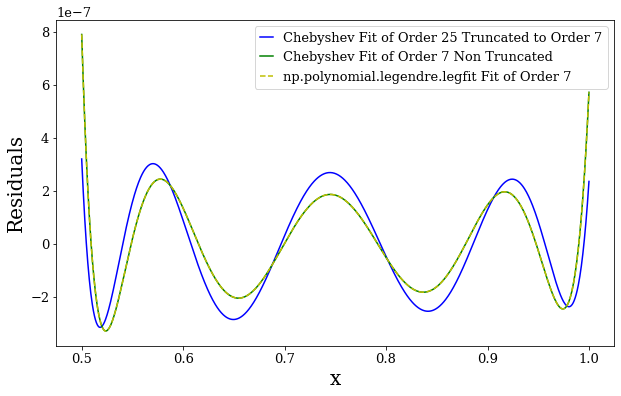

In [11]:
#Legendre polynomial fit
poly_coef = np.polynomial.legendre.legfit(x, data, deg=trunc -
                                          1)  # -1 to make the same order
pred_leg = np.polynomial.legendre.legval(x, poly_coef)

# non truncated Chebyshev Fit
pred_non_trunc = Cheb_fit(x, nb_points, trunc - 1,
                          data)  #trunc -1 has trunc starts at 1.

plt.figure(figsize=(10, 6))
plt.plot(x,
         pred,
         'bx',
         label='Chebyshev Fit of Order {} Truncated to Order {}'.format(
             order, trunc - 1))
plt.plot(x,
         pred_non_trunc,
         'gx',
         label='Chebyshev Fit of Order {} Non Truncated'.format(trunc - 1))

plt.plot(x,
         pred_leg,
         'yx',
         label='np.polynomial.legendre.legfit Fit of Order {}'.format(trunc -
                                                                      1))
plt.plot(x, data, 'r--', label='Truth')

plt.xlabel('x')
plt.ylabel('Fit')
plt.legend()

max_err = np.max(np.abs(pred - data))
rms = np.std(pred - data)

max_err_non_trunc = np.max(np.abs(pred_non_trunc - data))
rms_non_trunc = np.std(pred_non_trunc - data)

max_err_leg = np.max(np.abs(pred_leg - data))
rms_leg = np.std(pred_leg - data)

plt.figure(figsize=(10, 6))

plt.plot(x,
         pred - data,
         'b-',
         label='Chebyshev Fit of Order {} Truncated to Order {}'.format(
             order, trunc - 1))

plt.plot(x,
         pred_non_trunc - data,
         'g-',
         label='Chebyshev Fit of Order {} Non Truncated'.format(trunc - 1))

plt.plot(x,
         pred_leg - data,
         'y--',
         label='np.polynomial.legendre.legfit Fit of Order {}'.format(trunc -
                                                                      1))

plt.xlabel('x')
plt.ylabel('Residuals')
plt.legend()

In [12]:
print('For Chebyshev Fit of Order {} Truncated to Order {}.'.format(
    order, trunc - 1))
print('RMS error is: {:.12e}, Max error is: {:.12e}'.format(rms, max_err))

print('\nFor Chebyshev Fit of Order {} Non Truncated.'.format(trunc - 1))
print('RMS error is: {:.12e}, Max error is: {:.12e}'.format(
    rms_non_trunc, max_err_non_trunc))

print('\nFor np.polynomial.legendre.legfit Fit of Order {}.'.format(trunc - 1))
print('RMS error is: {:.12e}, Max error is: {:.12e}'.format(
    rms_leg, max_err_leg))

For Chebyshev Fit of Order 25 Truncated to Order 7.
RMS error is: 1.919202003936e-07, Max error is: 3.196978306530e-07

For Chebyshev Fit of Order 7 Non Truncated.
RMS error is: 1.685251824666e-07, Max error is: 7.888699566916e-07

For np.polynomial.legendre.legfit Fit of Order 7.
RMS error is: 1.685251823437e-07, Max error is: 7.888699755654e-07


 As seen in class, the truncated Chebyshev fit has a RMS error higer than the non truncated one but has a smaller max error. We can see that for the non truncated one, the deviation is huge at the endpoints. It is also seen that the Chebyshev fit (non truncated) has similar RMS and max error for same order compared to numpy legendre polynomial fit.

# Q3: Decay Products of U238

For this problem, we will use the Radau solver as it is stiff so we should use the implicit technique.

In [13]:
half_lifeTable = {
    "U238": {
        'half_life': 4.468e9,
        'unit': 'years'
    },
    "Th234": {
        'half_life': 24.10,
        'unit': 'days'
    },
    "Pa234": {
        'half_life': 6.70,
        'unit': 'hours'
    },
    "U234": {
        'half_life': 245500,
        'unit': 'years'
    },
    "Th230": {
        'half_life': 75380,
        'unit': 'years'
    },
    "Ra226": {
        'half_life': 1600,
        'unit': 'years'
    },
    "Rn222": {
        'half_life': 3.8235,
        'unit': 'days'
    },
    "Po218": {
        'half_life': 3.10,
        'unit': 'minutes'
    },
    "Pb214": {
        'half_life': 26.8,
        'unit': 'minutes'
    },
    "Bi214": {
        'half_life': 19.9,
        'unit': 'minutes'
    },
    "Po214": {
        'half_life': 164.3e-6,
        'unit': 'seconds'
    },
    "Pb210": {
        'half_life': 22.3,
        'unit': 'years'
    },
    "Bi210": {
        'half_life': 5.015,
        'unit': 'years'
    },  #years #days on wiki though...
    "Po210": {
        'half_life': 138.376,
        'unit': 'days'
    },
    #"Pb206": "stable"
}

half_lifeTable_y = half_lifeTable.copy()

for element in half_lifeTable.keys():

    if half_lifeTable[element]['unit'] == 'days':
        half_lifeTable_y[element]['half_life'] /= 365.25

    if half_lifeTable[element]['unit'] == 'minutes':
        half_lifeTable_y[element]['half_life'] /= (60 * 24 * 365.25)

    if half_lifeTable[element]['unit'] == 'hours':
        half_lifeTable_y[element]['half_life'] /= (24 * 365.25)

    if half_lifeTable[element]['unit'] == 'seconds':
        half_lifeTable_y[element]['half_life'] /= (60 * 24 * 365.25 * 60)

In [14]:
def bateman_equation(t, y, half_life):

    dydt = np.zeros(len(half_life) +
                    1)  #+1 to add the stable element equation at the end

    dydt[0] = -y[0] / half_life[0]

    for i in range(0, len(half_life) - 1):
        #second decay comes from production of [0] but also still decays.
        dydt[i + 1] = (y[i] / half_life[i] -
                       y[i + 1] / half_life[i + 1]) * np.log(2)

    #final product doesn't decay. It comes from production [-2]
    dydt[-1] = y[len(half_life) - 1] / half_life[len(half_life) - 1]

    return dydt * np.log(2)

In [15]:
half_life = []
for key in half_lifeTable_y.keys():
    half_life.append(half_lifeTable_y[key]['half_life'])

t0 = 0
t1 = 1e10
nbpoints = 100000
y0 = np.zeros(len(half_life) + 1)
y0[t0] = 1

sol = scipy.integrate.solve_ivp(
    fun=lambda t, y: bateman_equation(t, y, half_life),
    t_span=[t0, t1],
    t_eval=np.linspace(t0, t1, nbpoints),
    y0=y0,
    method='Radau')

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


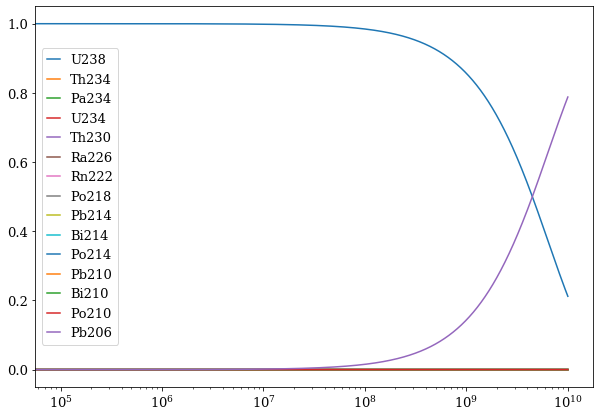

In [16]:
plt.figure(figsize=(10, 7))
for i, data in enumerate(sol.y):
    if i < len(half_life):
        plt.semilogx(sol.t, data, label=list(half_lifeTable.keys())[i])
    if i == len(half_life):
        plt.semilogx(sol.t, data, label='Pb206')

plt.legend()

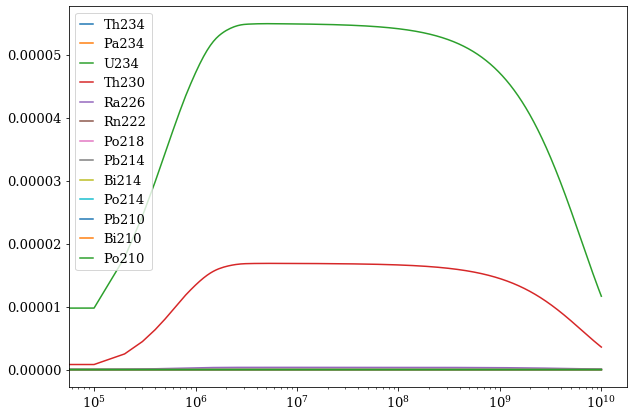

In [17]:
# just a zoom in...
plt.figure(figsize=(10, 7))
for i, data in enumerate(sol.y):
    if i > 0 and i < len(half_life) and i < len(half_life):
        plt.semilogx(sol.t, data, label=list(half_lifeTable.keys())[i])
plt.legend()

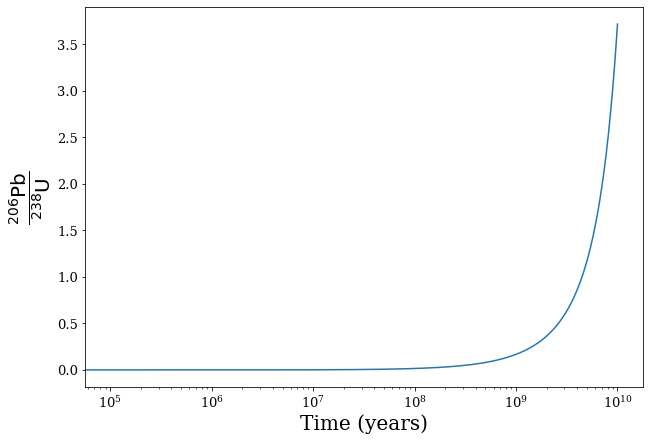

In [18]:
plt.figure(figsize=(10, 7))
plt.xlabel('Time (years)')
plt.ylabel(r"$\dfrac{\mathrm{^{206}Pb}}{\mathrm{^{238}U}}$")
plt.semilogx(sol.t, sol.y[-1] / sol.y[0], '-')
plt.show()

The ratio of Pb206 to U238 looks like it is exponentially rising. It makes sense analytically. 
Indeed, the quantity of product increases exponentially down the chain of exponentially decaying species and there is no loss term for Pb206 in the bateman equation.
Thus Pb206 will accumulate as U238 decays to zero, making the ratio blow up.

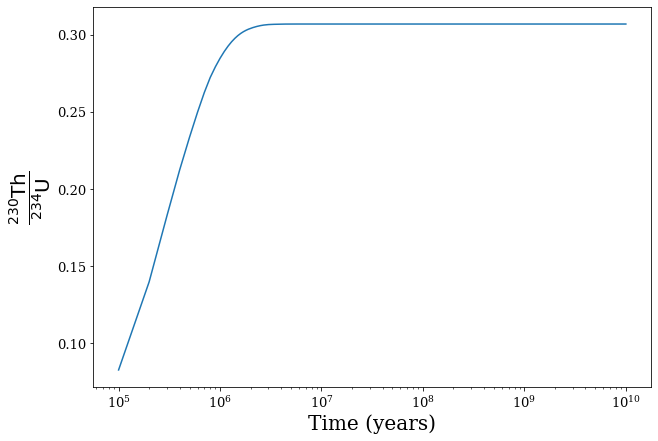

In [19]:
plt.figure(figsize=(10, 7))
plt.ylabel(r"$\dfrac{\mathrm{^{230}Th}}{\mathrm{^{234}U}}$")
plt.xlabel('Time (years)')
plt.semilogx(sol.t[1:], sol.y[4][1:] / sol.y[3][1:])  #Pb206 / U234
plt.show()

The ratio of Th230 to U234 looks like it is increasing to an equilibrium value of around 0.3. It makes sense analytically as first, U234 will accumulate exponentially. During some of this time, Th-230 is still close to zero, but after a certain time, it will also increases exponentially. 
At some point, their growth rates (and then decay rates after enough time passes) will be almost equal, giving rise to the equilibrium value observed.